In [1]:
# general purpose python
import collections
import datetime
import glob
import importlib
import itertools
import json
import math
import os
import pickle
import random
import re
import shutil
import sys
import time
import warnings

# general purpose data science
import IPython
import ipywidgets as ipw
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import download_plotlyjs
import pylab
import scipy
import seaborn as sns
import sklearn
from sklearn import *
import statsmodels as sm

# computer vision
import cv2
import imageio
import PIL
from PIL import *

# deep learning
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

# geospatial
import rasterio as rio
import rasterio.features

warnings.filterwarnings('ignore')

np.random.seed(1337)

mpl.rcParams['figure.dpi'] = 400

IPython.core.display.display(IPython.core.display.HTML("<style>.container { width:100% !important; }</style>"))

pd.options.display.max_colwidth = 32
pd.options.display.float_format = '{:,.6f}'.format
pd.options.display.expand_frame_repr = False

%matplotlib inline

sns.set(font_scale=1.3)
sns.set_style('whitegrid')
sns.set_palette(sns.color_palette('muted'))

plotly.offline.init_notebook_mode(connected=True)
plotly.io.templates.default = 'plotly_white'

### Prepare the data

In [17]:
batch_size = 128

img_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.5], [0.5])])

train_dataset = torchvision.datasets.MNIST(root='../data/torchvision_data_root',
                                           train=True,
                                           download=True,
                                           transform=img_transform)

train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_dataset = torchvision.datasets.MNIST(root='../data/torchvision_data_root',
                                          train=False,
                                          download=True,
                                          transform=img_transform)

test_loader = torch.utils.data.DataLoader(test_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

### Build the autoencoder

In [18]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 64),
            nn.ReLU(True),
            nn.Linear(64, 16),
            nn.ReLU(True),
            nn.Linear(16, 4))
        self.decoder = nn.Sequential(
            nn.Linear(4, 16),
            nn.ReLU(True),
            nn.Linear(16, 64),
            nn.ReLU(True),
            nn.Linear(64, 28 * 28),
            nn.Tanh())

    def forward(self, x):
        h = self.encoder(x)
        y = self.decoder(h)
        return y
    
model = AutoEncoder().cuda()

### Training

In [45]:
n_epochs = 10
learning_rate = 1e-4
weight_decay = 1e-5

loss = nn.MSELoss()
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate,
    weight_decay=weight_decay)

training_history = {
    'train_loss': [],
    'test_loss': []}

def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 1, 28, 28)
    return x

for epoch in range(n_epochs):
    for train_data in train_loader:
        x, _ = train_data
        x = x.view(x.size(0), -1)
        x = torch.autograd.Variable(x).cuda()
        y = model(x)
        l = loss(x, y)
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
    if epoch == 0 or (epoch + 1) % 5 == 0:
        print(f'epoch: {epoch + 1}/{n_epochs}    train loss: {l.data.item():.4f}')

epoch: 1/10    train loss: 0.1490
epoch: 5/10    train loss: 0.1424
epoch: 10/10    train loss: 0.1446


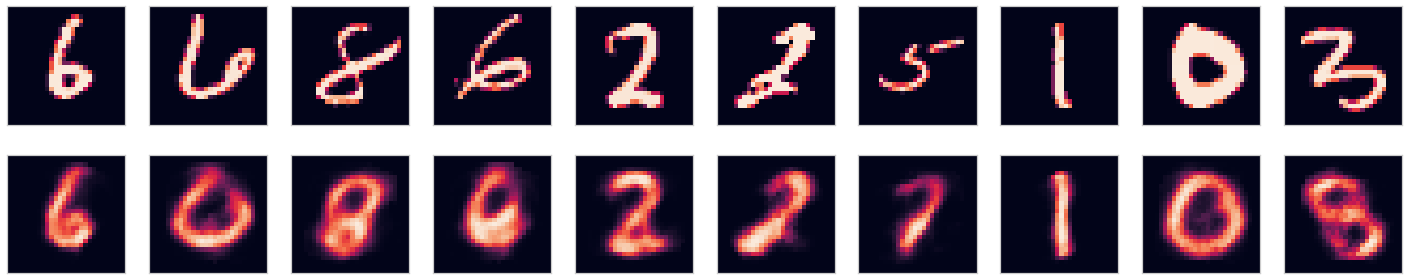

In [48]:
x, _ = next(iter(test_loader))
x = x.view(x.size(0), -1)
x = torch.autograd.Variable(x).cuda()
y = model(x)

x = to_img(x.cpu().data)
y = to_img(y.cpu().data)
d = [x, y]

plt.figure(figsize=(25, 5))
for i in range(10):
    for j in range(2):
        plt.subplot(2, 10, i + 1 + j*10)
        plt.imshow(d[j][i][0])
        plt.xticks([])
        plt.yticks([])
plt.show()